# Variables and Helpers

In [34]:
'''Globals

'''
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import factory
import pandas as pd
import datetime

green_color = '#AEBD38'
blue_color = '#68829E'

file_expressions = [r'.{0,}.log',
                    r'.{0,}Flitz.{0,}.log',
                    r'.{0,}Kinect.{0,}.log',
                    ]
expr_idx = 0
logfile_idx = 1
dir_name = 'Kin_FBMC_logs_1'
log_file_paths = ['text_logs',
                  'ExtraLogs/Kin_FBMC/logs_1',
                  'ExtraLogs/Kin_FBMC/logs_2',
                  'ExtraLogs/Kin_FBMC/logs_3',
                  'ExtraLogs/Kin_FBMC/logs_4',
                  'ExtraLogs/Kin_FBMC/logs_5_inklMulti',
                  'ExtraLogs/Kin_Single_Multi/logs/',
                  'ExtraLogs/Kin_Single_Multi/logs1/',
                  'ExtraLogs/Kin/logs/',
                  'ExtraLogs/Kin/logs1/',
                    ]

rel_files= []
dataframes = []
conc_dataframes = []
conc_dataframes_with_hr = []

def init_rel_files():
    global rel_files
    rel_files = [f for f in sorted(os.listdir(logs_path)) if re.search(file_expressions[expr_idx], f)]


def init_dataframes():
    global dataframes
    logs = [logs_path + "/" +  s for s in rel_files]
    column_names = ['Time','Logtype','Gamemode','Points','Heartrate','physDifficulty','psyStress','psyDifficulty','obstacle']
    dataframes = list(pd.read_csv(log, sep=';', skiprows=5, index_col=False, names=column_names) for log in logs)

def add_timedelta_column():
    global dataframes
    for idx, df in enumerate(dataframes):
        new = df['Time'].apply(lambda x: datetime.timedelta(seconds=x))
        dataframes[idx] = dataframes[idx].assign(timedelta=new)
        
def add_user_and_round():
        for idx, df in enumerate(dataframes):
            df.insert(10, 'userID', np.full( (len(df.index),1), int(np.floor(idx/2))))
            # m = re.search(r'(\d)_[0,1]',rel_files[idx], re.IGNORECASE)
            match = re.search('(\d)_(\d+)', rel_files[idx])  # add if round 0 or 1
            if match:
                df.insert(11, 'round', np.full( (len(df.index),1), match.group(1)))
            else:
                df.insert(11, 'round', np.full( (len(df.index),1), 0))
            dataframes[idx] = df

def get_colors():
    colors = ['red'] * len(conc_dataframes)
    for idx, user_id in enumerate(conc_dataframes.groupby(['userID', 'round'])['userID'].max()):
        if user_id % 2 == 0:
            colors[idx] = '#68829E'
        else:
              colors[idx] = '#AEBD38'
    return colors

def filter_out_short_dataframes():
    global dataframes, rel_files
    min_length = 200 #seconds
    frames = []
    files = []

    for idx, df in enumerate(dataframes):
        if (df['Time'].max() >min_length):
            frames.append(df) 
            files.append(rel_files[idx])
    dataframes = frames
    rel_files= files
    

def get_number_of_obstacles_per_difficulty(conc):
    conc_num = factory.transformToNumbers(conc) # Transform Difficulties into integers
    # count num.obstacle parts per obstacle
    new = conc_num['obstacle'].apply(lambda x: 0 if x=='none' else x.count(",") + 1 ) 
    conc_num = conc_num.assign(numObstacles=new)

    # number of occurences per diff&numObstacles
    cnt = pd.DataFrame({'count' : conc_num.groupby(['physDifficulty','numObstacles']).size()}).reset_index()    
    numObst = [0]*15
    count=0
    for a in range(0,len(cnt.index)):
        d= cnt['physDifficulty'][a]
        o= cnt['numObstacles'][a]
        if not o ==0: # Filter out when there is no obstacle at all 
            numObst[(d-1)*5+o] = cnt['count'][count]
        count +=1
    return numObst

# Init

In [44]:
'''Init'''''

local_base_path = os.path.abspath(os.path.join(os.getcwd(),'../..'))
svn_base_path = local_base_path + '/Code/plunder planet'
logs_path = local_base_path +'/Logs/'+log_file_paths[logfile_idx]

init_rel_files()
init_dataframes()
add_timedelta_column()
add_user_and_round()
filter_out_short_dataframes()
conc_dataframes = pd.concat(dataframes, ignore_index=True)
conc_dataframes_with_hr = conc_dataframes[conc_dataframes['Heartrate']>30]
plt.tight_layout()

# Barplot: Playing time per user and round

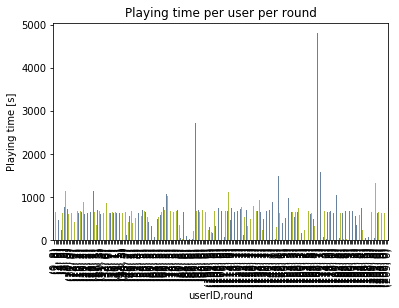

In [15]:
import re
'''Plot: Playing time per user 
'''
plt.ylabel('Playing time [s]')
plt.title('Playing time per user per round')

time_df = conc_dataframes.groupby(['userID', 'round'])['Time'].max()
time_df.plot.bar(color=get_colors())
#plt.savefig(svn_base_path + '/Plots/Extra Data/' + dir_name + '/playing_time_per_user.pdf')

# Plot: Average HR over all games

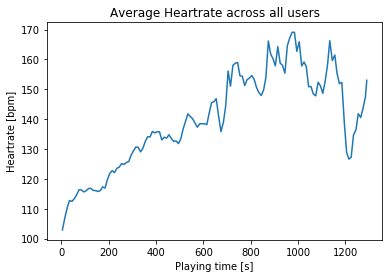

In [4]:
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator

'''Plot: Average Heartrate 
'''

fig, ax = plt.subplots()
plt.ylabel('Heartrate [bpm]')
plt.xlabel('Playing time [s]')
plt.title('Average Heartrate across all users')

resolution = 10 # resample every x seconds -> the bigger, the smoother

time_df = conc_dataframes_with_hr.groupby(['userID', 'round'])['Time'].max()
min_time = time_df.min()
mask = (conc_dataframes_with_hr['Time']<min_time)
conc_with_hr = conc_dataframes_with_hr[mask] # Cut all dataframes to the same minimal length
df_copy = conc_dataframes_with_hr.copy() # to prevent SettingWithCopyWarning
avg_hr_df = df_copy.groupby(['timedelta'])[['Time','Heartrate']].mean() # Take mean over all logfiles
avg_hr_df_resampled = avg_hr_df.resample(str(resolution)+'S').mean() # Resample series

plt.plot(avg_hr_df_resampled['Time'], avg_hr_df_resampled['Heartrate'])
plt.show()
plt.savefig(svn_base_path +  '/Plots/Extra Data/' + dir_name + '/average_heartrate.pdf')

# Boxplot: Mean and std HR 

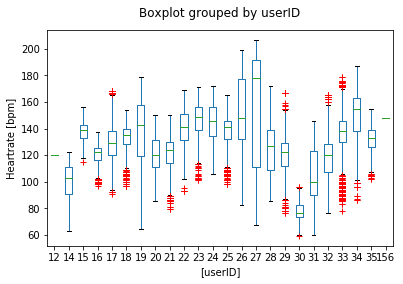

In [5]:
'''Plot: Mean and std bpm per user in a box-chart
'''

df2 = conc_dataframes_with_hr.pivot(columns=conc_dataframes_with_hr.columns[1], index=conc_dataframes_with_hr.index)
df2.columns = df2.columns.droplevel()
conc_dataframes_with_hr[['Heartrate','userID']].boxplot(by='userID', grid=False, sym='r+')
plt.ylabel('Heartrate [bpm]')
plt.title('')
plt.savefig(svn_base_path + '/Plots/Extra Data/' + dir_name +'/mean_heartrate_boxplot.pdf')

- 8 out of 14 users have HR data

# Barplot: Heartrate Change

In [ ]:
''' Plot Heartrate change
'''
bpm_changes_max = []  # Stores max. absolute change in HR per logfile 
bpm_changes_rel = [] # Stores max. percentage change in HR per logfile 


X = []
for idx, df in enumerate(dataframes):
    if not (df['Heartrate'] < 10).any():
        X.append(idx)
        resampled = factory.resample_dataframe(df, 10)
        percentage_change = np.diff(resampled['Heartrate']) / resampled['Heartrate'][:-1] * 100.
        x = percentage_change[np.logical_not(np.isnan(percentage_change))]
        bpm_changes_max.append(x.max())
        bpm_changes_rel.append(x)
        plt.figure()
        plt.title('Heartrate plot' + str(idx))
        plt.plot(resampled['Time'],resampled['Heartrate'])
        plt.savefig(svn_base_path + '/Plots/Extra Data/' + dir_name + '/Heartrate Plots/heartrate_change_percentage' + rel_files[idx] + '.pdf')
plt.ylabel('#Times HR changed')
plt.xlabel('Change in Heartrate [%]')
for idx, l in enumerate(bpm_changes_rel):
    plt.figure()
    plt.title('Heartrate change for plot' + str(idx))
    plt.hist(l, color=green_color)
    plt.savefig(svn_base_path + '/Plots/Extra Data/' + dir_name + '/Heartrate Histograms/heartrate_change_percentage' + rel_files[idx]   + '.pdf')

plt.figure()
plt.title('Maximal heartrate change')
plt.ylabel('Max heartrate change [%]')
plt.xlabel('Logfile')
plt.bar([x for x in X], bpm_changes_max, color=blue_color, width=0.25)
plt.savefig(svn_base_path + '/Plots/Extra Data/' + dir_name +'/heartrate_change_abs.pdf')

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


- Most of the logfiles don't have unusual behavior uf the HR, menaing a maximal change of <20% between consecutive measurements 

# Helper: Plot Corr with Difficulty

In [49]:
from matplotlib.ticker import MaxNLocator
def plot_difficulty_corr_with(to_compare):
    resolution = 5 # resample every x seconds -> the bigger, the smoother
    for idx, df in enumerate(dataframes):
        if not (df['Heartrate'] < 10).any():
            X = []
            X.append(idx)
            df_num_resampled = factory.resample_dataframe(df, resolution)
            # Plot Heartrate
            fig, ax1 = plt.subplots()
            ax1.plot(df_num_resampled['Time'], df_num_resampled[to_compare], blue_color)
            ax1.set_xlabel('Playing time [s]')
            ax1.set_ylabel(to_compare, color=blue_color)
            ax1.tick_params('y', colors=blue_color)
            # Plot Difficulty 
            ax2 = ax1.twinx()
            ax2.set_ylabel('physDifficulty', color=green_color)
            ax2.tick_params('y', colors=green_color)
            ax2.yaxis.set_major_locator(MaxNLocator(integer=True)) # Only show whole numbers as difficulties
            ax2.plot(df_num_resampled['Time'], df_num_resampled['physDifficulty'], green_color)
            plt.savefig(svn_base_path + '/Plots/Extra Data/' + dir_name +'/'+to_compare+' Difficulty Corr/'+to_compare+'_difficulty_' +rel_files[idx] + '.pdf')

# Plot: Heartrate correlated with Difficulty

20 data_2016-03-11_16-57-54.log
21 data_2016-03-11_17-11-39.log
23 data_2016-03-12_10-18-25.log
24 data_2016-03-12_10-37-37.log
25 data_2016-03-12_10-56-14.log
26 data_2016-03-12_11-19-21.log
27 data_2016-03-12_11-38-45.log
30 data_2016-03-12_12-39-40.log
31 data_2016-03-12_13-07-37.log
32 data_2016-03-12_13-23-59.log
33 data_2016-03-12_13-54-25.log
34 data_2016-03-12_14-12-42.log
35 data_2016-03-12_14-42-42.log
36 data_2016-03-12_14-58-21.log
37 data_2016-03-12_15-35-46.log
38 data_2016-03-12_15-54-45.log
39 data_2016-03-12_16-16-08.log
40 data_2016-03-12_16-31-15.log
41 data_2016-03-12_16-51-49.log
42 data_2016-03-12_17-09-39.log
43 data_2016-03-12_17-24-53.log


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


44 data_2016-03-12_17-48-52.log
46 data_2016-03-13_14-26-05.log
47 data_2016-03-13_14-39-01.log
48 data_2016-03-13_14-47-45.log
49 data_2016-03-13_15-19-36.log
50 data_2016-03-13_16-18-50.log
51 data_2016-03-13_16-29-08.log
52 data_2016-03-13_16-35-36.log
53 data_2016-03-16_14-06-47.log
54 data_2016-03-16_14-24-25.log
55 data_2016-03-16_14-37-39.log
58 data_2016-03-16_15-31-23.log
59 data_2016-03-16_15-48-42.log
60 data_2016-03-16_16-10-35.log
61 data_2016-03-16_16-24-34.log


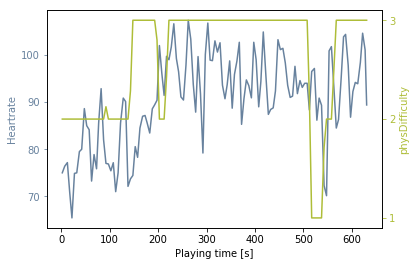

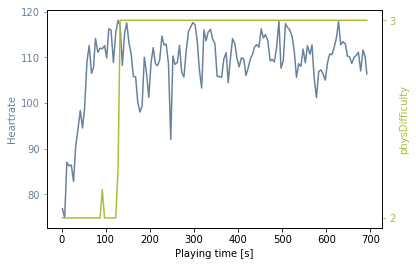

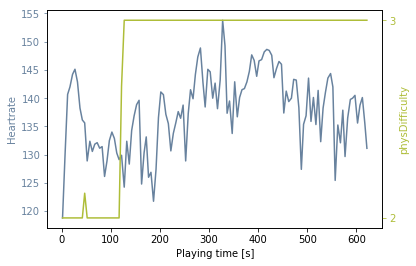

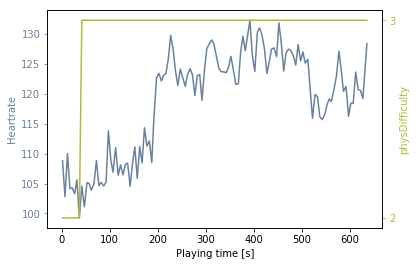

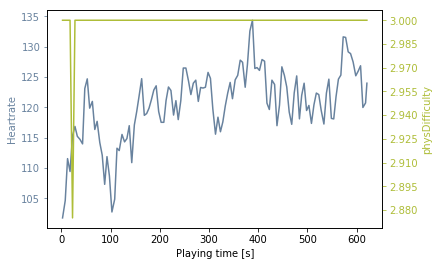

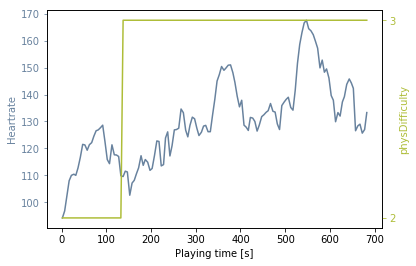

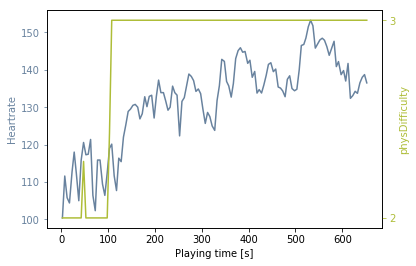

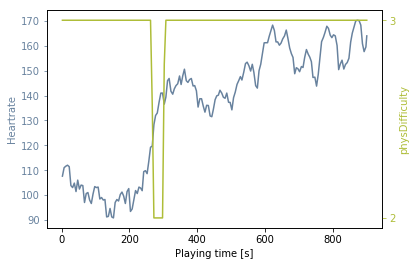

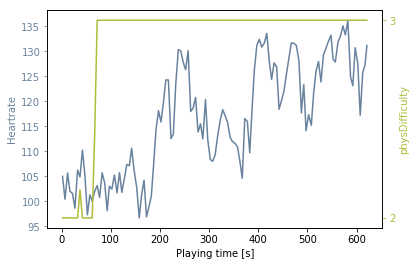

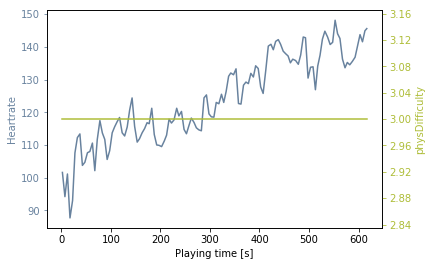

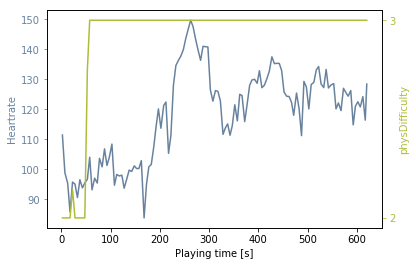

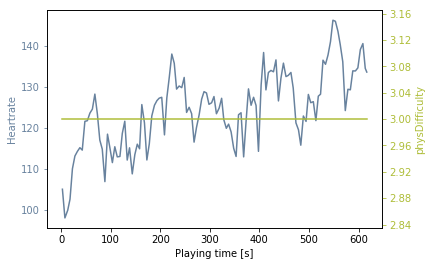

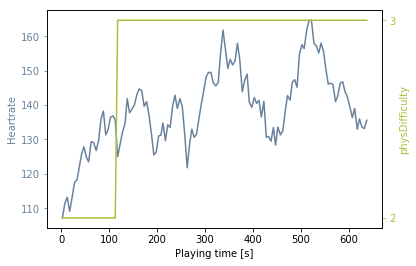

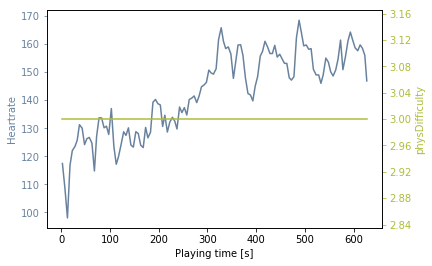

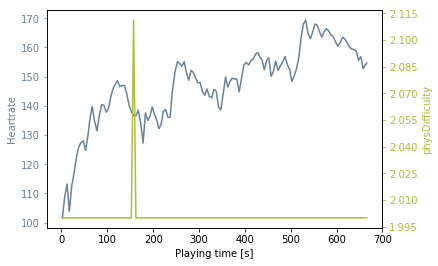

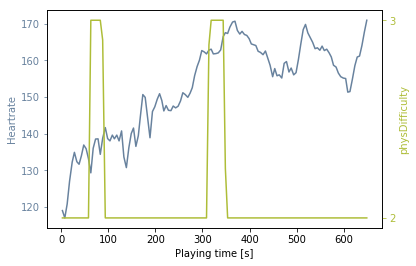

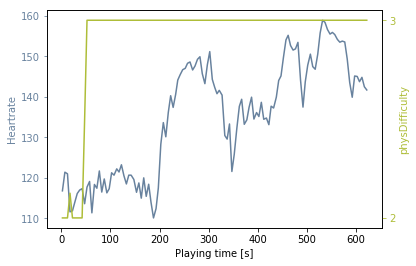

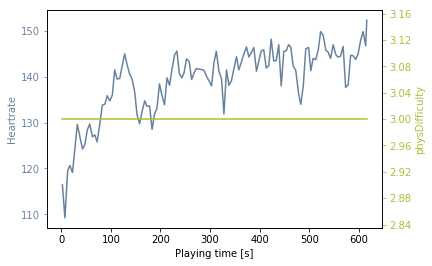

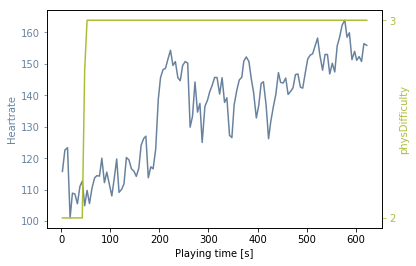

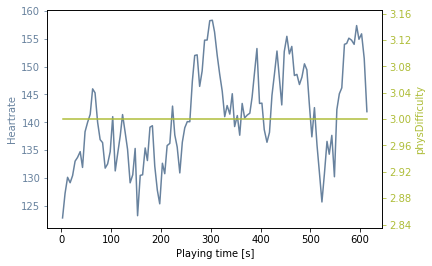

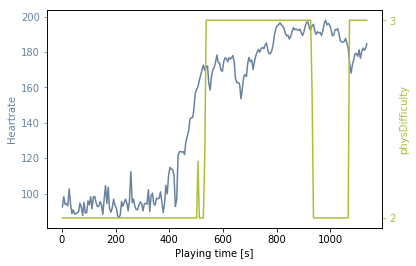

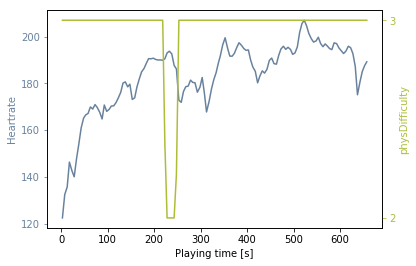

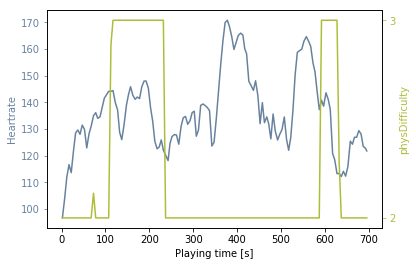

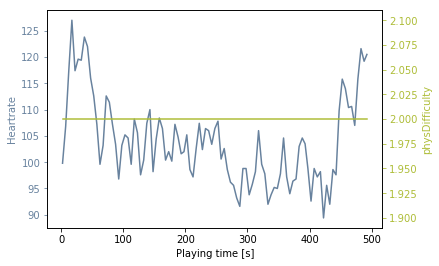

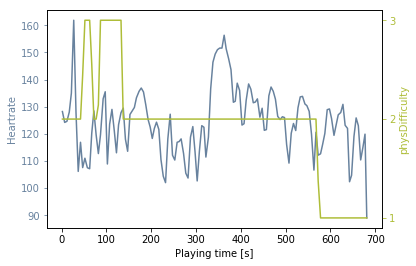

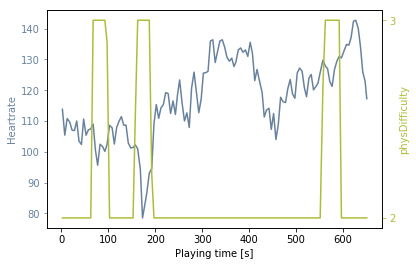

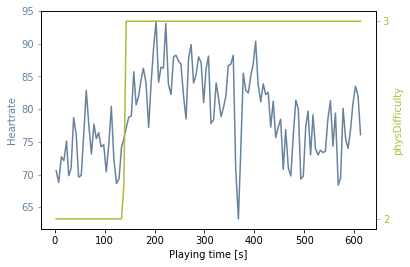

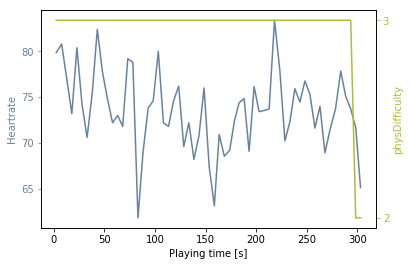

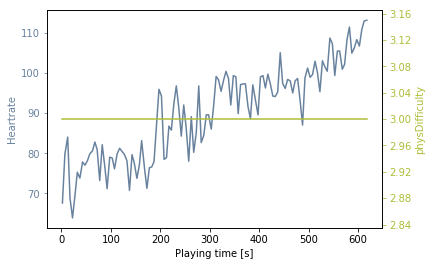

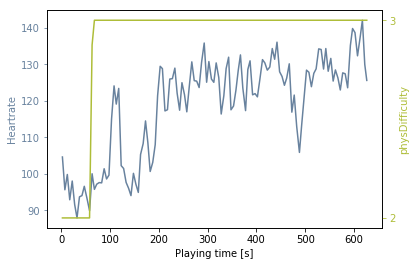

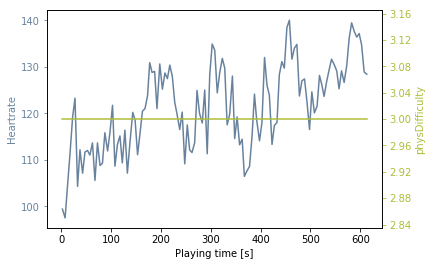

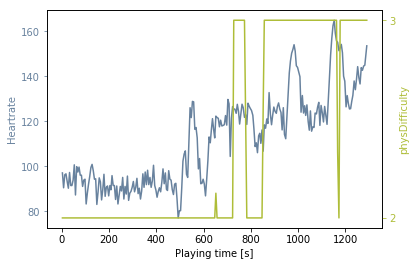

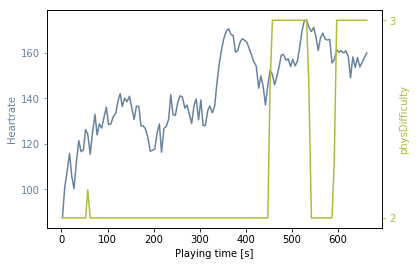

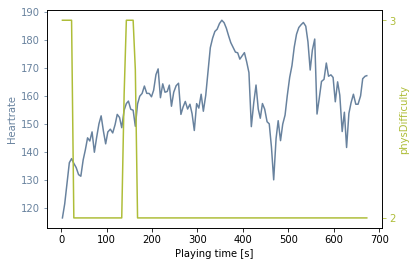

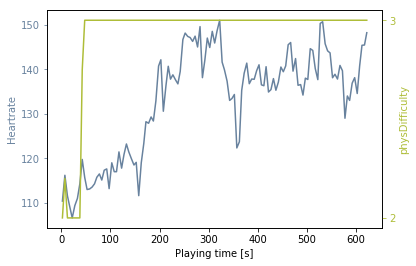

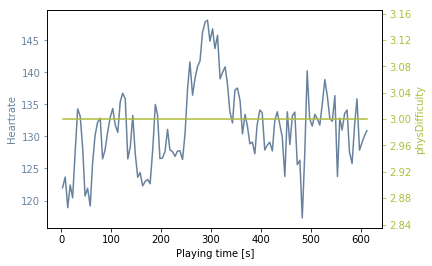

In [47]:
plot_difficulty_corr_with('Heartrate')

- Not a lot of difficulty changes unfortunately
- A small correlation

# Plot: Points correlated with Difficulty

20 data_2016-03-11_16-57-54.log
21 data_2016-03-11_17-11-39.log
23 data_2016-03-12_10-18-25.log
24 data_2016-03-12_10-37-37.log
25 data_2016-03-12_10-56-14.log
26 data_2016-03-12_11-19-21.log
27 data_2016-03-12_11-38-45.log
30 data_2016-03-12_12-39-40.log
31 data_2016-03-12_13-07-37.log
32 data_2016-03-12_13-23-59.log
33 data_2016-03-12_13-54-25.log
34 data_2016-03-12_14-12-42.log
35 data_2016-03-12_14-42-42.log
36 data_2016-03-12_14-58-21.log
37 data_2016-03-12_15-35-46.log
38 data_2016-03-12_15-54-45.log
39 data_2016-03-12_16-16-08.log
40 data_2016-03-12_16-31-15.log
41 data_2016-03-12_16-51-49.log
42 data_2016-03-12_17-09-39.log
43 data_2016-03-12_17-24-53.log
44 data_2016-03-12_17-48-52.log


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


46 data_2016-03-13_14-26-05.log
47 data_2016-03-13_14-39-01.log
48 data_2016-03-13_14-47-45.log
49 data_2016-03-13_15-19-36.log
50 data_2016-03-13_16-18-50.log
51 data_2016-03-13_16-29-08.log
52 data_2016-03-13_16-35-36.log
53 data_2016-03-16_14-06-47.log
54 data_2016-03-16_14-24-25.log
55 data_2016-03-16_14-37-39.log
58 data_2016-03-16_15-31-23.log
59 data_2016-03-16_15-48-42.log
60 data_2016-03-16_16-10-35.log
61 data_2016-03-16_16-24-34.log


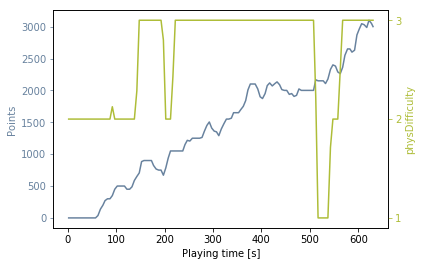

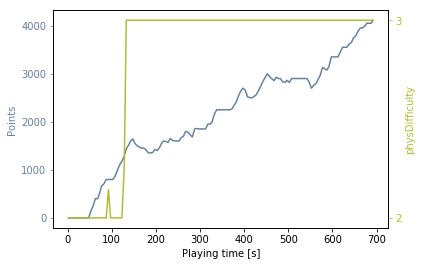

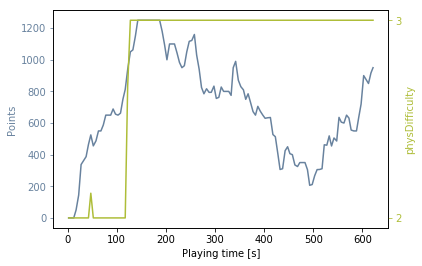

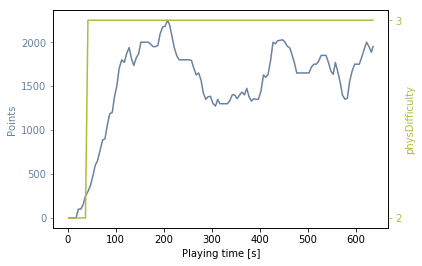

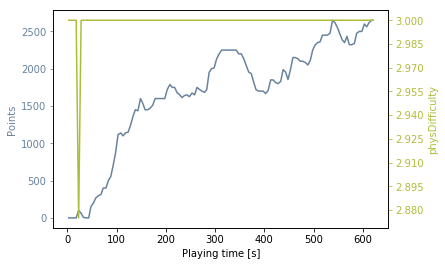

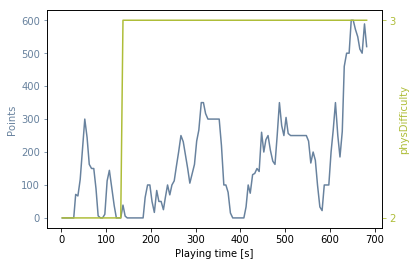

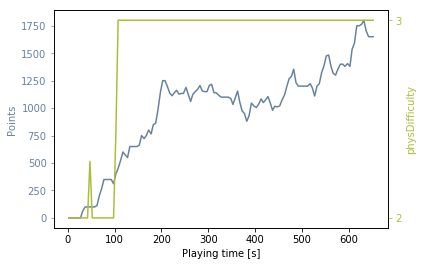

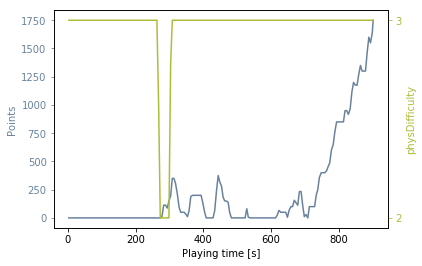

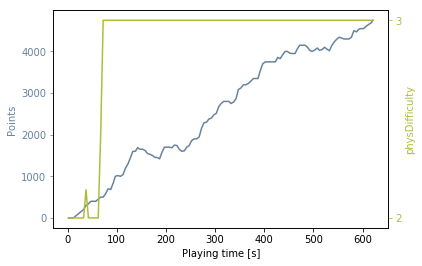

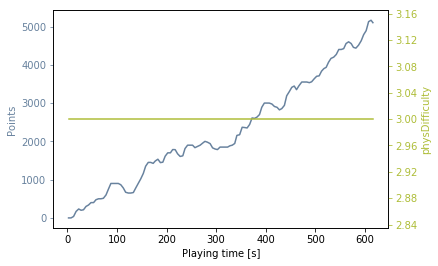

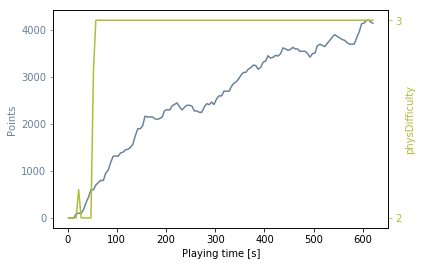

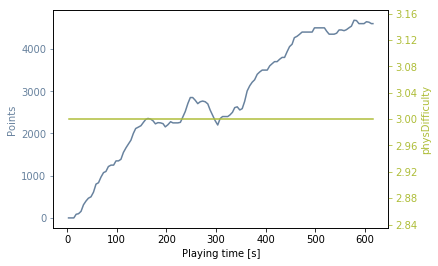

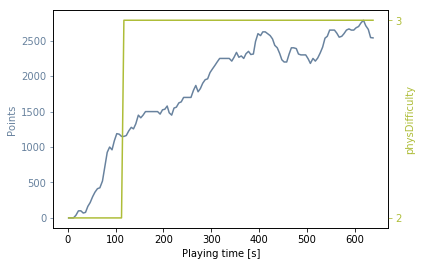

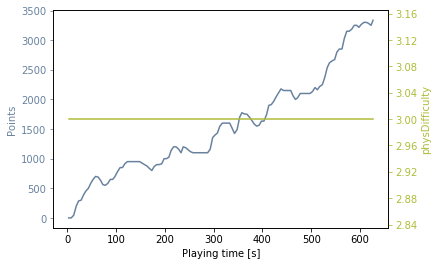

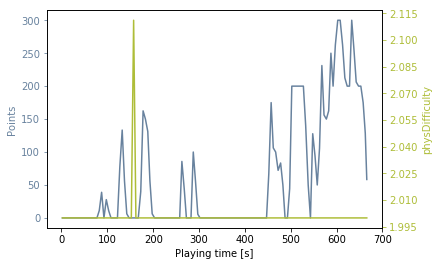

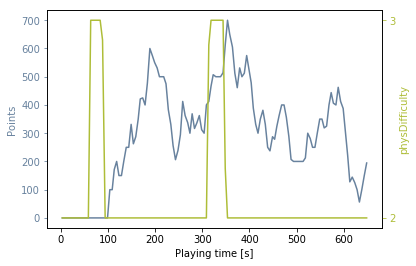

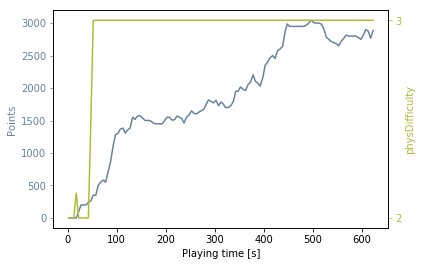

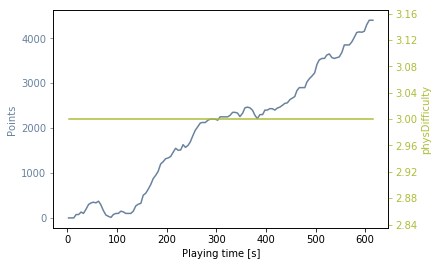

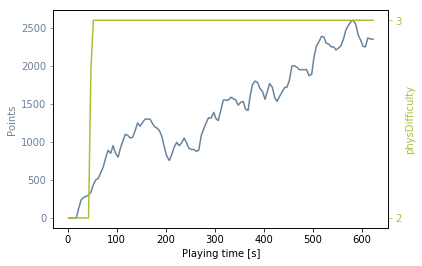

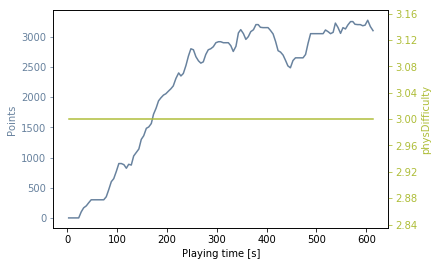

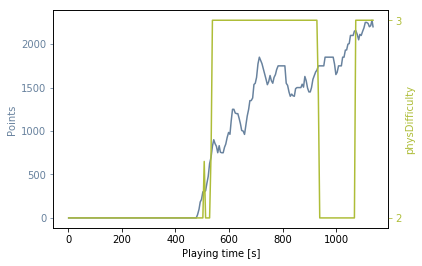

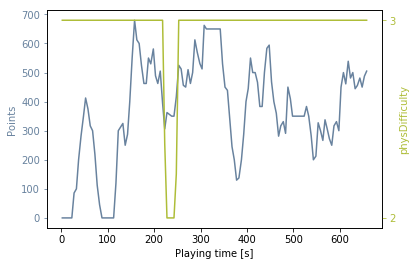

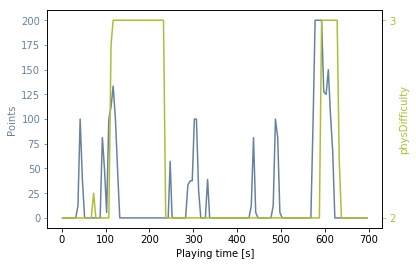

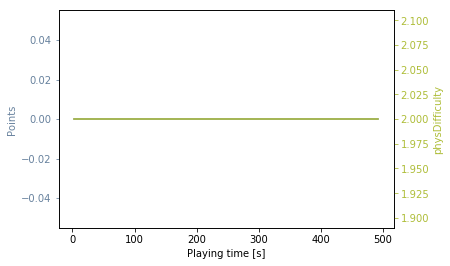

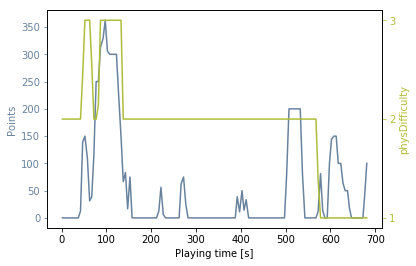

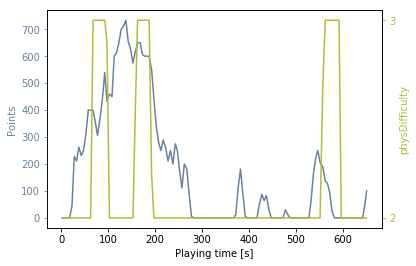

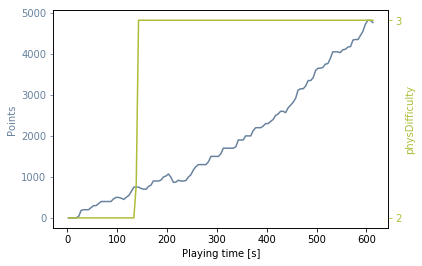

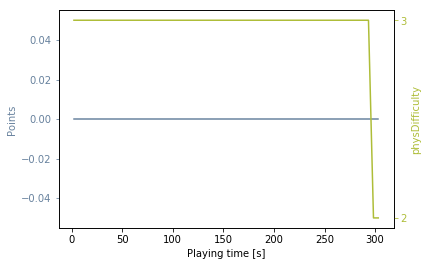

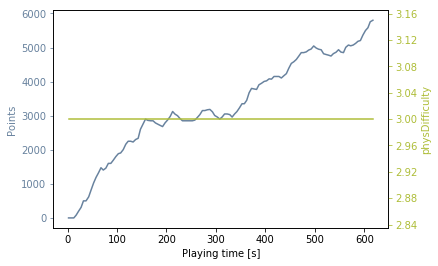

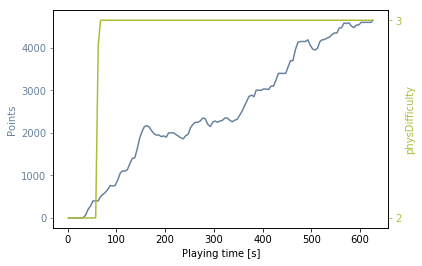

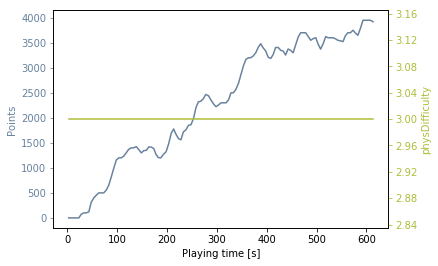

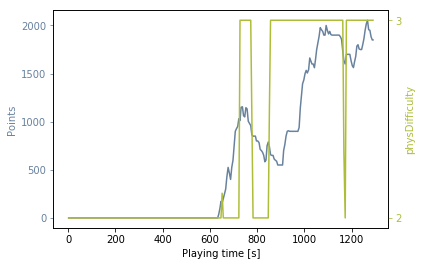

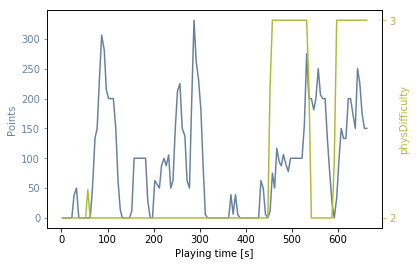

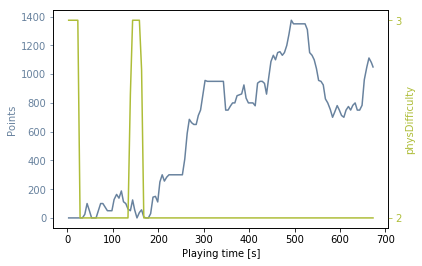

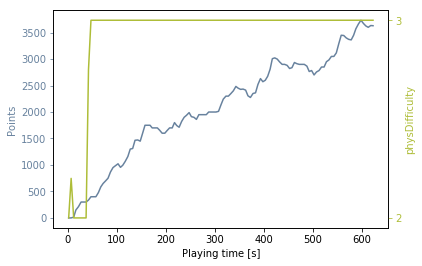

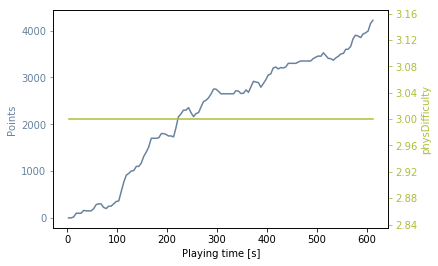

In [48]:
plot_difficulty_corr_with('Points')

# Scatter plot: Difficulty vs. size of obstacles 

[0, 966, 2172, 223, 29, 0, 6286, 109, 16155, 376, 0, 11222, 50, 3580, 20557]


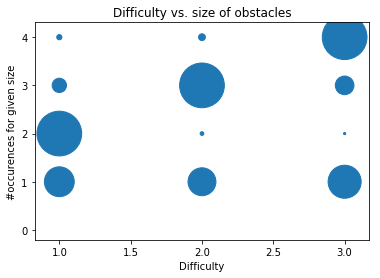

In [50]:
plt.figure()
#print(conc_num.groupby(['physDifficulty','numObstacles']).size())
values = get_number_of_obstacles_per_difficulty(conc_dataframes)
print(values)

#normalize values per difficulty
for i in [0,1,2]:
    li = values[5*i:5*i+5]
    maximum = max(li)
    values[5*i:5*i+5] = [x / maximum * 2000 for x in li] 
plt.title('Difficulty vs. size of obstacles')
plt.ylabel('#occurences for given size')
plt.xlabel('Difficulty')
x = [1,1,1,1,1,2,2,2,2,2,3,3,3,3,3]
y = [0,1,2,3,4,0,1,2,3,4,0,1,2,3,4]
plt.scatter(x, y, s=values)
plt.savefig(svn_base_path +  '/Plots/Extra Data/' + dir_name +'/corr_difficulty_numObstacles.pdf')

Difficulty level corresponds mostly to bigger obstacles

# Obstacle Information

In [51]:
#### Idea: Get % of crashes per difficulty level
df = conc_dataframes

grouped2 = df.groupby(['physDifficulty', 'Logtype']).size()
print(grouped2)

print('\nOn physDifficulty=HIGH, there were ' + str(grouped2[4]) + \
      ' obstacles, out of which the user crashed ' + str(grouped2[1]) + \
      ', i.e. ' + str(round(grouped2[1]/grouped2[4],2)*100) + '%.' )

print('On physDifficulty=MEDIUM, there were ' + str(grouped2[14]) + \
      ' obstacles, out of which the user crashed ' + str(grouped2[16]) + \
      ', i.e. ' + str(round(grouped2[14]/grouped2[16],2)*100) + '%.' )

print('On physDifficulty=LOW, there were ' + str(grouped2[25]) + \
      ' obstacles, out of which the user crashed ' + str(grouped2[27]) + \
      ', i.e. ' + str(round(grouped2[25]/grouped2[27],2)*100) + '%.' )



physDifficulty  Logtype                           
HIGH            CONTINUOUS                            77932
                EVENT_CRASH                           12830
                EVENT_ENDPHASEI                           1
                EVENT_ENDPHASEII                          1
                EVENT_OBSTACLE                        35409
                EVENT_PICKUP                           4751
                EVENT_PLAYERACTION_MOVEBOTTOMLEFT      2646
                EVENT_PLAYERACTION_MOVEBOTTOMRIGHT     3117
                EVENT_PLAYERACTION_MOVETOPLEFT          499
                EVENT_PLAYERACTION_MOVETOPRIGHT         384
                EVENT_PLAYERACTION_SHIELDLEFT           510
                EVENT_PLAYERACTION_SHIELDRIGHT          429
                EVENT_STARTPHASEII                        1
LOW             CONTINUOUS                            12548
                EVENT_CRASH                            1081
                EVENT_ENDPHASEI                  

#  Scatter plot: Difficulty vs HR

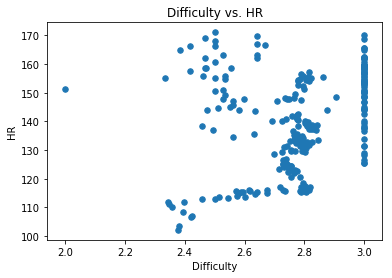

In [12]:
df = conc_dataframes_with_hr
df_num = factory.transformToNumbers(df)
df_num.set_index('timedelta', inplace=True)
resolution=5
# resample and take mean over difficulty. This means that a point can now have a difficulty "between"
# Low/Medium/High, depending on how many seconds out of the resolution seconds it was on which level.
avg_hr_df_resampled = df_num.resample(str(resolution)+'S').mean() 

plt.title('Difficulty vs. HR')
plt.ylabel('HR')
plt.xlabel('Difficulty')
x = avg_hr_df_resampled['physDifficulty']
y = avg_hr_df_resampled['Heartrate']
plt.scatter(x, y, s=30)
plt.savefig(svn_base_path +  '/Plots/Extra Data/' + dir_name +'/corr_difficulty_HR.pdf')

- Difficulty indeed has an influence on Heartrate


# Barplot:  Crashes vs size of obstacle

Num_Obstacles: [370718, 18721, 2341, 21187, 21212]
Crashes: [0, 7085, 617, 8090, 7901]


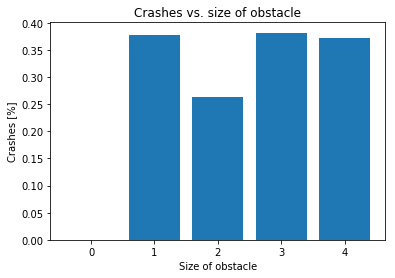

In [13]:
#For an index i, find next index in dataframe where we have an EVENT_OBSTACLE
def get_next_obstacle_idx(index):
    not_done = True
    idx = index +1 
    while not_done:
        next_row = conc_num.iloc[idx]
        if next_row['Logtype'] == 'EVENT_OBSTACLE':
            not_done=False
        else:
            idx+=1
    return idx

conc_num = factory.transformToNumbers(conc_dataframes) # Transform Difficulties into integers
new = conc_num['obstacle'].apply(lambda x: 0 if x=='none' else x.count(",") + 1 ) # count number of obstacle parts per obstacle
conc_num = conc_num.assign(numObstacles=new)
# [a,b,c,d,e], e..g  #obstacles that had size 0,1,2,3,4 respectively
num_obstacles_per_size = conc_num.groupby('numObstacles').size().tolist()
print('Num_Obstacles: ' + str(num_obstacles_per_size))
num_crashes_per_size = [0,0,0,0,0]
#For each crash, find corresponding row where we can find the size of the obstacle he crashed into.
for index, row in conc_num.iterrows():
    if (row['Logtype']=='EVENT_CRASH'):
        next_obstacle_idx = get_next_obstacle_idx(index)
        sizeOfObstacle = conc_num.iloc[next_obstacle_idx]['numObstacles']
        num_crashes_per_size[sizeOfObstacle] +=1       
percentage_of_crashes = [0 if (x==0 | y==0) else x/y for x, y in zip(num_crashes_per_size, num_obstacles_per_size)]     
print('Crashes: ' + str(num_crashes_per_size))
x = [0,1,2,3,4]
plt.title('Crashes vs. size of obstacle')
plt.ylabel('Crashes [%]')
plt.xlabel('Size of obstacle')
plt.bar(x, percentage_of_crashes)

plt.savefig(svn_base_path +  '/Plots/Extra Data/' + dir_name + '/crashes_per_size_of_obstacles.pdf')

- Bigger obstacle doesn't really mean that the chance for the user to crash is bigger!

# %Crashes in the last 30 seconds

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


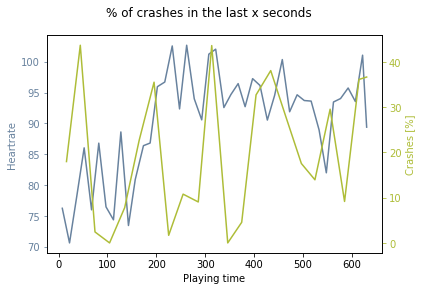

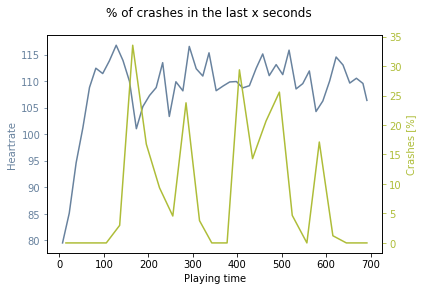

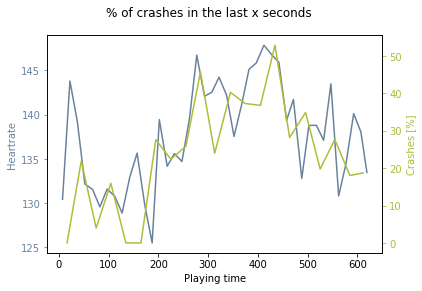

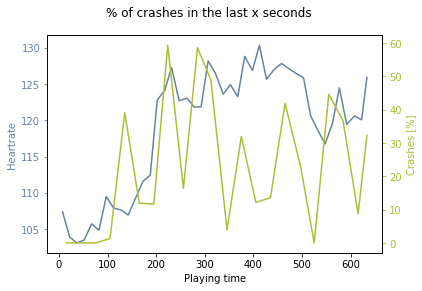

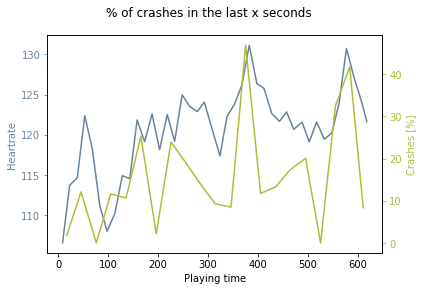

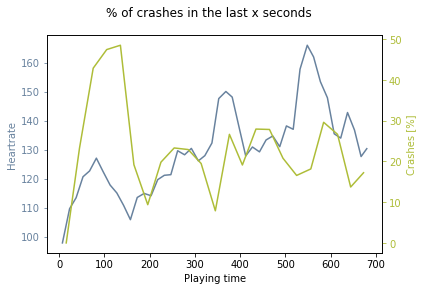

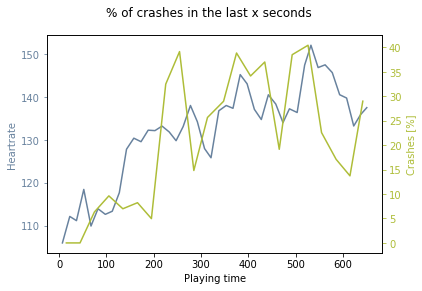

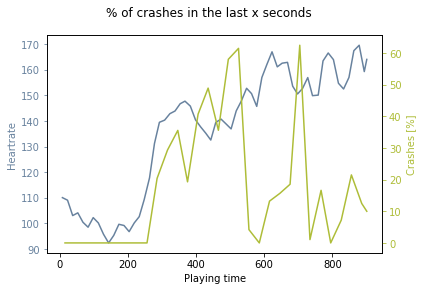

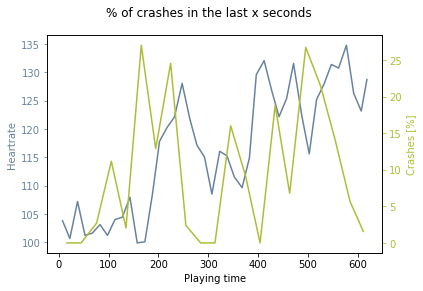

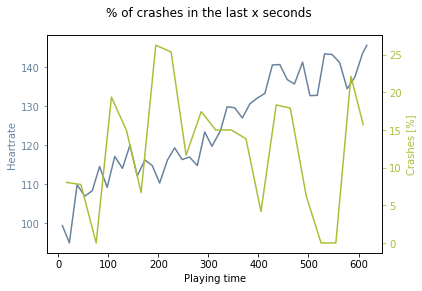

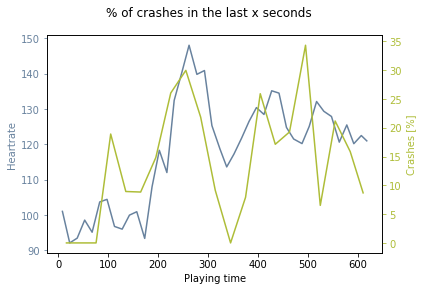

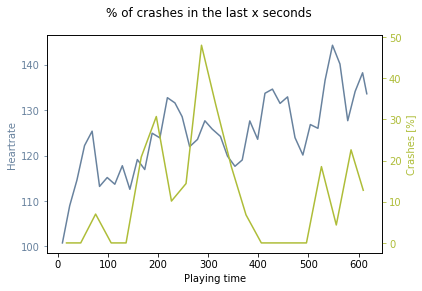

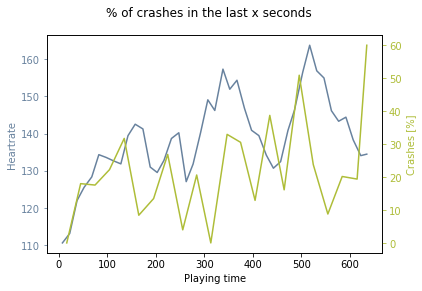

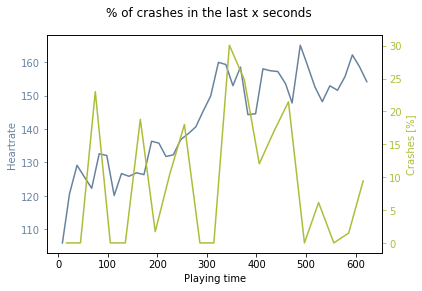

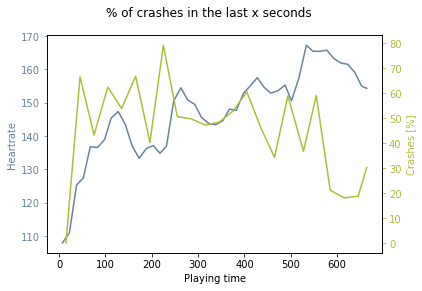

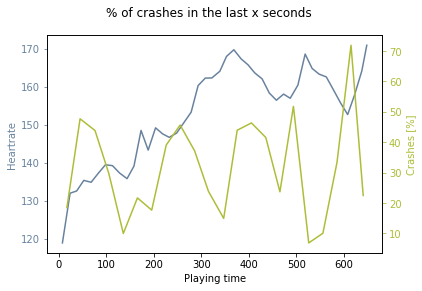

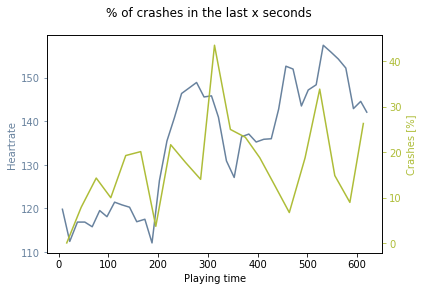

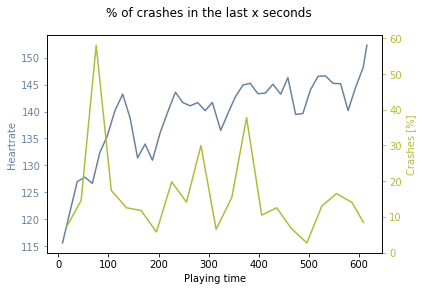

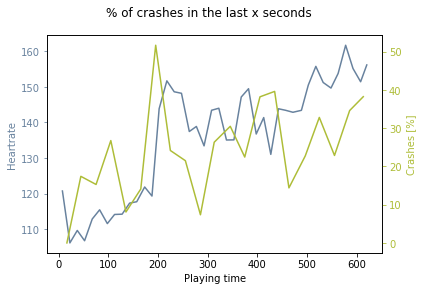

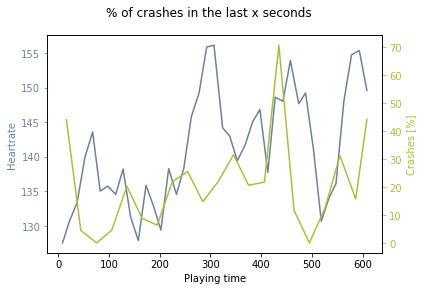

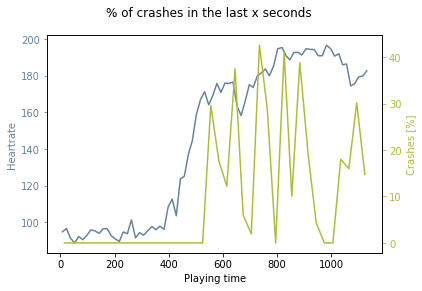

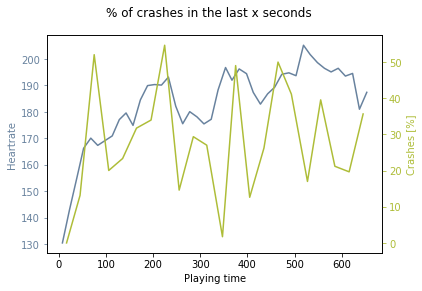

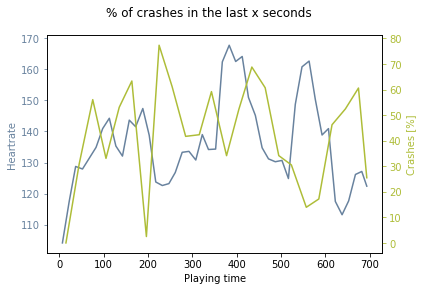

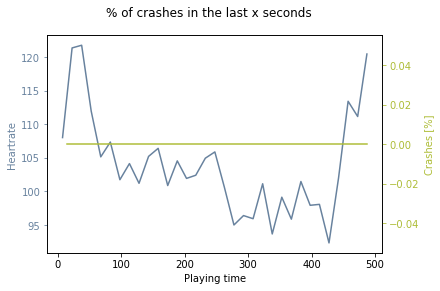

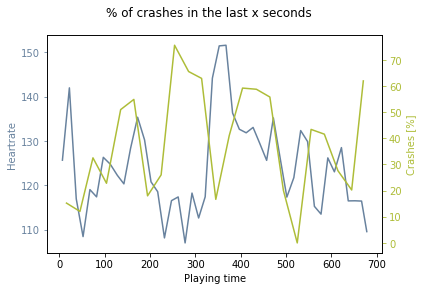

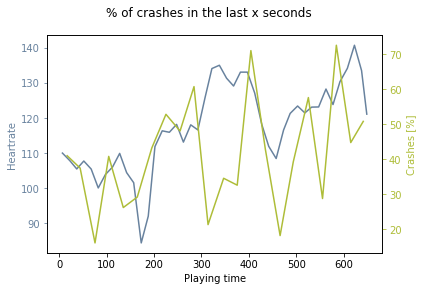

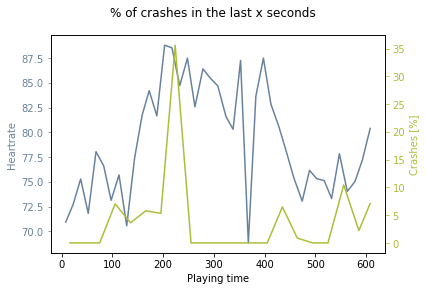

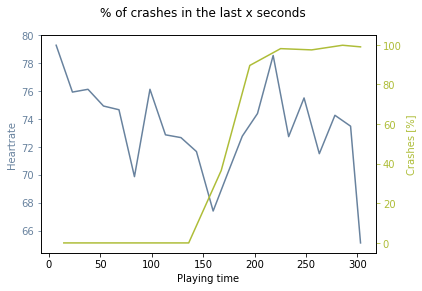

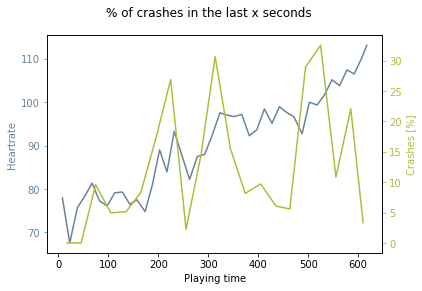

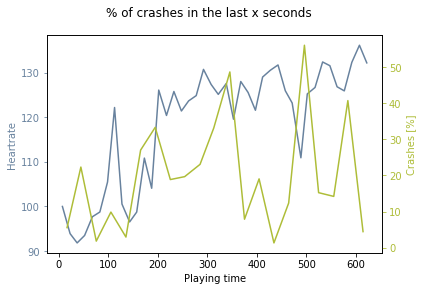

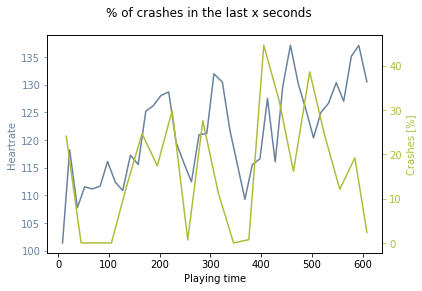

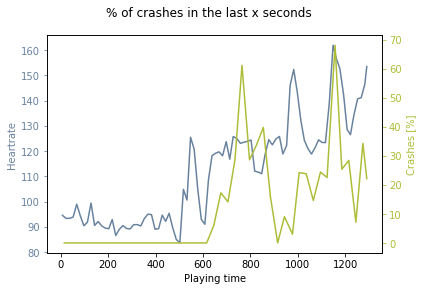

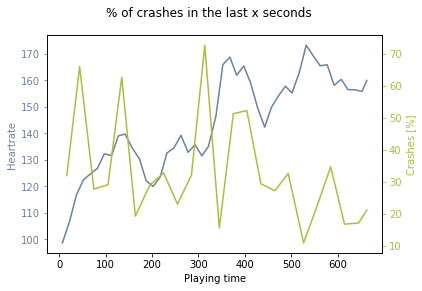

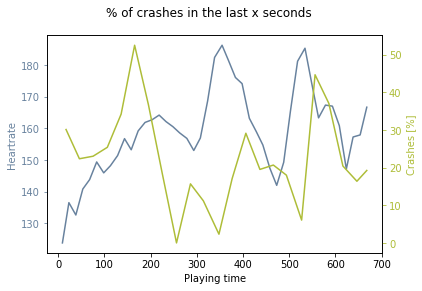

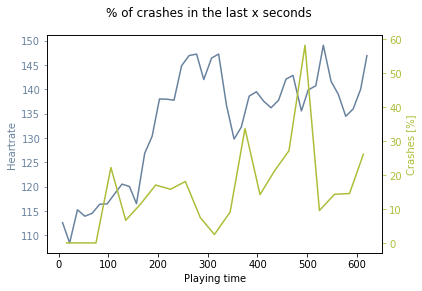

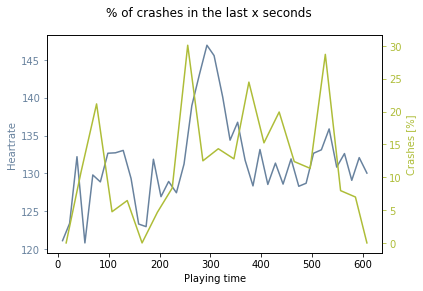

In [53]:
window = 15 #Over how many seconds should we caluculate %crashes?
resolution_heartrate = 15 #Resampling interval
resolution_crashes = 30
def df_from_to(_from, _to):
    mask = (_from<df['Time']) & (df['Time']<=_to)
    return df[mask]
    
def computeCrashes(row):
    last_x_seconds_df = df_from_to(max(0,row['Time']-window), row['Time'])
    num_obstacles = len(last_x_seconds_df[last_x_seconds_df['Logtype']=='EVENT_OBSTACLE'].index)
    num_crashes = len(last_x_seconds_df[last_x_seconds_df['Logtype']=='EVENT_CRASH'].index)
    return (num_crashes/num_obstacles *100 if num_crashes<num_obstacles else 100) if num_obstacles!=0 else 0



for idx, df in enumerate(dataframes):
        if not (df['Heartrate'] < 10).any():
                # Plot Heartrate
                fig, ax1 = plt.subplots()
                fig.suptitle('% of crashes in the last x seconds')
                df_num_resampled = factory.resample_dataframe(df, resolution_heartrate)
                #print(df_num_resampled)
                ax1.plot(df_num_resampled['Time'], df_num_resampled['Heartrate'], blue_color)
                ax1.set_xlabel('Playing time')
                ax1.set_ylabel('Heartrate', color=blue_color)
                ax1.tick_params('y', colors=blue_color)

                #Plot %crashes
                ax2 = ax1.twinx()
                df['%crashes'] = df[['Time', 'Logtype']].apply(computeCrashes,axis=1)
                resampled = factory.resample_dataframe(df, resolution_crashes)
                ax2.plot(resampled['Time'], resampled['%crashes'], green_color)
                ax2.set_ylabel('Crashes [%]', color=green_color)
                ax2.set_xlabel('Time')
                ax2.tick_params('y', colors=green_color)

                plt.savefig(svn_base_path +  '/Plots/Extra Data/' + dir_name +'/%Crashes/%crashes_heartrate_' +rel_files[idx]  + '.pdf')
